## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *
from collections import defaultdict
import csv
from datetime import datetime
import os
import random
import time


## Read and preprocess data


In [2]:
def load_data(file_path):
    data_dict = dict()

    with open(file_path) as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row['Numéro du groupe'] != '':
                heures, minutes, _ = map(int, row['TransitTime'].split(':')) 
                total_minutes = heures * 60 + minutes
                data_dict[int(float(row['Numéro du groupe']))] = (
                    int(float(row['Femmes'])),
                    int(float(row['Hommes'])),
                    int(float(row['WCHR'])),
                    total_minutes
                )

    return data_dict

# Load data for each file

file_names = ["DataSeating 2024.csv","22Oct.csv","23Oct.csv","24Oct.csv","30Oct.csv", "5Nov.csv", "7Nov.csv"]
data_directory = 'data'
# for eachy dictionary : dict[Numéro du groupe : (Femmes, Hommes, WCHR, TransitTime)]
Oct21, Oct22,Oct23, Oct24, Oct30, Nov5, Nov7= [load_data(os.path.join(data_directory, file)) for file in file_names]

Transforming data to access each passenger's Id


In [3]:
def create_passengers_dict(data):
    passengers_dict = {}
    j = 1

    for group_num, group_data in data.items():
        weights = {'Femmes': 70, 'Hommes': 85, 'WCHR': 100}  # Weight per passenger

        # Extracting data
        femmes, hommes, wchr, total_minutes = group_data

        # Enumerating passengers
        for _ in range(femmes + hommes + wchr):
            if femmes > 0:
                weight = weights['Femmes']
                passengers_dict[j] = {'gender': 'Femmes', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                femmes -= 1
            elif hommes > 0:
                weight = weights['Hommes']
                passengers_dict[j] = {'gender': 'Hommes', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                hommes -= 1
            else:
                weight = weights['WCHR']
                passengers_dict[j] = {'gender': 'WCHR', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                wchr -= 1
            j += 1

    return passengers_dict

Passengers_Oct21 = create_passengers_dict(Oct21)
Passengers_Oct22 = create_passengers_dict(Oct22)
Passengers_Oct23 = create_passengers_dict(Oct23)
Passengers_Oct24 = create_passengers_dict(Oct24)
Passengers_Oct30 = create_passengers_dict(Oct30)
Passengers_Nov5 = create_passengers_dict(Nov5)
Passengers_Nov7 = create_passengers_dict(Nov7)

# Example usage for Nov5
print(Passengers_Nov5)

{1: {'gender': 'Femmes', 'group': 1, 'weight': 70, 'connection_time': 0}, 2: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 3: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 4: {'gender': 'Hommes', 'group': 2, 'weight': 85, 'connection_time': 60}, 5: {'gender': 'Femmes', 'group': 3, 'weight': 70, 'connection_time': 165}, 6: {'gender': 'Hommes', 'group': 3, 'weight': 85, 'connection_time': 165}, 7: {'gender': 'Femmes', 'group': 4, 'weight': 70, 'connection_time': 0}, 8: {'gender': 'Hommes', 'group': 4, 'weight': 85, 'connection_time': 0}, 9: {'gender': 'WCHR', 'group': 4, 'weight': 100, 'connection_time': 0}, 10: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 11: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 12: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 13: {'gender': 'Femmes', 'group': 6, 'weight': 70, 'connection_time': 0}, 14: {'gender': 'Hommes', 'group': 6, 'weig

# Static model

In [4]:
# Function to create optimization model and variables

ranks = 29  # number of rows in the aircraft
ns = 7 * ranks  # number of seats

def create_model_and_variables(passengers_dict):
    n = len(passengers_dict)  # number of passengers

    m = Model('statique')  # Model initialization

    # Adding variables
    S = {(i, j): m.addVar(vtype=GRB.BINARY, name=f'j{i}') for i in range(1, n + 1) for j in range(1, ns + 1)}

    # Adding constraints
    # Max. 1 seat per passenger
    for j in range(1, ns + 1):
        m.addConstr(sum(S[(i, j)] for i in range(1, n + 1)) <= 1, name="PassengerMax")

    # Each passenger has one and only one seat
    for i in range(1, n + 1):
        m.addConstr(sum(S[(i, j)] for j in range(1, ns + 1)) == 1, name="SeatMax")

    # The central aisle is left free
    for i in range(1, n + 1):
        for j in range(1, ns + 1):
            if j % 7 == 4:
                m.addConstr(S[(i, j)] == 0)

    # Baricenter
    x_g = LinExpr()
    y_g = LinExpr()

    total_weight = quicksum(passengers_dict[i]['weight'] for i in range(1, n + 1)).getValue()

    for i in range(1, n + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = passengers_dict[i]['weight'] / total_weight

            if j % 7 == 0:
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j] * weight_ij)

    m.addConstr(x_g >= 3)
    m.addConstr(x_g <= 5)
    m.addConstr(y_g >= 13)
    m.addConstr(y_g <= 17)

    # Disabled passengers occupy 4 spaces on the central aisle
    for passenger in passengers_dict:
        if passengers_dict[passenger]['gender']=='WCHR':
            #Seats are shortened by row (from 7 to 7)
            for j in range(1, ns+1-8, 7):             
            
                x1, x2, x3, x4, x5, x6, x7 = j,j+1,j+2,j+3,j+4,j+5,j+6
                
                #A seat is fixed in rows 3 or 5.
                m.addConstr(S[(passenger, x1)] + S[(passenger, x3)] +  S[(passenger, x5)] + S[(passenger, x7)] ==0 )   
                
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x2+1)] for i in passengers_dict) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x2+7)] for i in passengers_dict) <= 1) 
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x2+8)] for i in passengers_dict) <= 1)
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x6-1)] for i in passengers_dict) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x6+7)] for i in passengers_dict) <= 1) 
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x6+6)] for i in passengers_dict) <= 1)
            #Disabled passengers cannot be in the last row   
            m.addConstr(sum(S[(passenger, k)] for k in range (ns-6, ns+1)) == 0)  

    return m, S

In [5]:
#Choice of the dictionnary

Passengers=Passengers_Oct21

In [6]:
# Create models and variables for each date
n=len(Passengers)
m, S = create_model_and_variables(Passengers)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-04


Objective functions

In [7]:
# Transit passengers are seated at the front of the aircraft
def obj_transit(S, passengers_dict):
    T = {}

    for passenger in passengers_dict:
        if passengers_dict[passenger]['connection_time'] > 0:  # transit passenger
            T[passenger] = passengers_dict[passenger]['connection_time']

    P = list(T.keys())  # returns a list of transit passenger identifiers

    f = 0
    for k in range(len(P)):
        for j in range(1, ns + 1):
            q = (j - 1) // 7
            f += S[(P[k], j)] * (1 / T[P[k]]) * q

    return f


In [8]:
def seat_coordinates(seats):  #seats is a list
    coordinates = []
    for j in range(len(seats)):
        if (seats[j] % 7 == 0):
            x = 7
            y = (seats[j] // 7) 
        else:
            x = seats[j] % 7
            y = (seats[j] // 7) +1 
        coordinates.append((x, y))
    return coordinates

print (seat_coordinates([1, 54]))

[(1, 1), (5, 8)]


In [9]:
alpha=0.3

def obj_dist(Passengers, alpha):

    obj = LinExpr()
    X={}
    Y={}
    coord = seat_coordinates([j for j in range(1, ns+1)])
    for i in range(1, n + 1):
        X[i]=m.addVar(vtype=GRB.INTEGER)
        Y[i]=m.addVar(vtype=GRB.INTEGER)

        for k in range(i + 1, n + 1):  
            if  i!=k and Passengers[i]['group'] == Passengers[k]['group']:  #Si passager i et passager k sont dans le même groupe

                xi, yi = 0, 0
                xk, yk = 0, 0

                for j in range (len(coord)):                                      #On parcourt les sièges
                    xi, yi = xi + S[(i,j+1)]*coord[j][0], yi + S[(i,j+1)]*coord[j][1]
                    xk, yk =  xk + S[(k,j+1)]*coord[j][0], yk + S[(k,j+1)]*coord[j][1]
                
                m.addConstr(X[i]>=xi - xk)
                m.addConstr(X[i]>= -xi + xk)
                m.addConstr(Y[i]>=yi - yk)
                m.addConstr(Y[i]>= -yi + yk)
                dist_x = X[i] 
                dist_y = Y[i]
                obj += alpha*dist_x + (1-alpha)*dist_y  
                
    return obj



In [10]:

m.setObjective(obj_transit(S, Passengers) + obj_dist(Passengers, alpha) , GRB.MINIMIZE)

In [11]:
# Choice of minimalist display settings
m.params.outputflag = 0 # mute mode
m.update() # Model update
display(m) # Text mode display of PL



<gurobi.Model MIP instance statique: 4925 constrs, 30955 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

In [12]:
#Resolution
m.Params.timeLimit = 120
m.optimize()
# Solution display 
print()
print("Seats on the plane are as follows:", [(i, j) for i in range(1, len(Passengers) + 1) for j in range(1, ns + 1) if S[(i, j)].x])




Seats on the plane are as follows: [(1, 31), (2, 126), (3, 112), (4, 187), (5, 83), (6, 84), (7, 190), (8, 79), (9, 41), (10, 42), (11, 80), (12, 136), (13, 97), (14, 96), (15, 24), (16, 138), (17, 168), (18, 167), (19, 98), (20, 43), (21, 1), (22, 2), (23, 70), (24, 159), (25, 156), (26, 155), (27, 157), (28, 17), (29, 19), (30, 16), (31, 15), (32, 113), (33, 114), (34, 20), (35, 6), (36, 5), (37, 170), (38, 171), (39, 40), (40, 197), (41, 149), (42, 150), (43, 91), (44, 94), (45, 78), (46, 45), (47, 44), (48, 181), (49, 103), (50, 36), (51, 37), (52, 27), (53, 26), (54, 129), (55, 72), (56, 85), (57, 110), (58, 111), (59, 3), (60, 132), (61, 178), (62, 122), (63, 118), (64, 128), (65, 127), (66, 38), (67, 35), (68, 22), (69, 203), (70, 119), (71, 196), (72, 195), (73, 7), (74, 10), (75, 152), (76, 175), (77, 174), (78, 162), (79, 163), (80, 50), (81, 51), (82, 184), (83, 30), (84, 29), (85, 57), (86, 153), (87, 154), (88, 124), (89, 65), (90, 64), (91, 73), (92, 146), (93, 145), (94

Creation of a control dictionnary (dictionnaire témoin) of the results of the dynamic model. It will simplify our code for the dynamic model.

In [13]:
def valeurs_var(S) :
    val = {}
    for i in Passengers :
        for j in range(1,ns+1) :
            if S[(i,j)].x :
                val[(i,j)] = 1
            else :
                val[(i,j)] = 0
    return(val)
temoin_S = valeurs_var(S)
print(temoin_S)

{(1, 1): 0, (1, 2): 0, (1, 3): 0, (1, 4): 0, (1, 5): 0, (1, 6): 0, (1, 7): 0, (1, 8): 0, (1, 9): 0, (1, 10): 0, (1, 11): 0, (1, 12): 0, (1, 13): 0, (1, 14): 0, (1, 15): 0, (1, 16): 0, (1, 17): 0, (1, 18): 0, (1, 19): 0, (1, 20): 0, (1, 21): 0, (1, 22): 0, (1, 23): 0, (1, 24): 0, (1, 25): 0, (1, 26): 0, (1, 27): 0, (1, 28): 0, (1, 29): 0, (1, 30): 0, (1, 31): 1, (1, 32): 0, (1, 33): 0, (1, 34): 0, (1, 35): 0, (1, 36): 0, (1, 37): 0, (1, 38): 0, (1, 39): 0, (1, 40): 0, (1, 41): 0, (1, 42): 0, (1, 43): 0, (1, 44): 0, (1, 45): 0, (1, 46): 0, (1, 47): 0, (1, 48): 0, (1, 49): 0, (1, 50): 0, (1, 51): 0, (1, 52): 0, (1, 53): 0, (1, 54): 0, (1, 55): 0, (1, 56): 0, (1, 57): 0, (1, 58): 0, (1, 59): 0, (1, 60): 0, (1, 61): 0, (1, 62): 0, (1, 63): 0, (1, 64): 0, (1, 65): 0, (1, 66): 0, (1, 67): 0, (1, 68): 0, (1, 69): 0, (1, 70): 0, (1, 71): 0, (1, 72): 0, (1, 73): 0, (1, 74): 0, (1, 75): 0, (1, 76): 0, (1, 77): 0, (1, 78): 0, (1, 79): 0, (1, 80): 0, (1, 81): 0, (1, 82): 0, (1, 83): 0, (1, 84): 0, 

Visualization of the seats

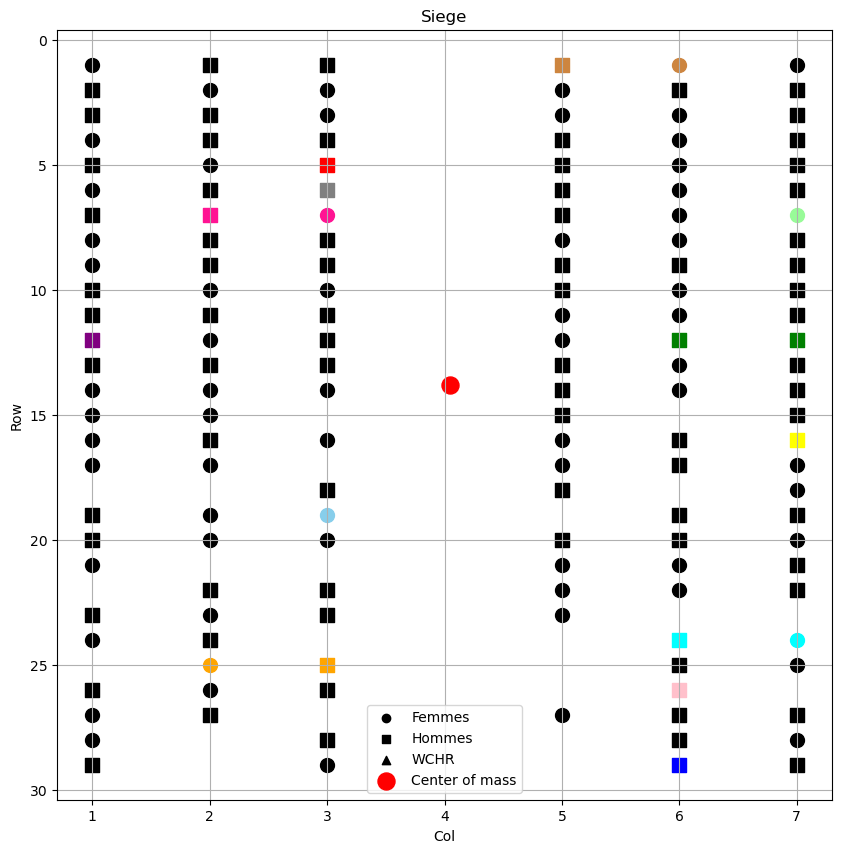

In [14]:
# Creating a variable called seats containing only the j coordinates
seats = [j for i in range(1, n + 1) for j in range(1, ns + 1) if S[(i, j)].x]
seat_coords = seat_coordinates(seats)


# Display the Baricenter

def calculate_center_of_mass(seat_coords, Passengers):
    x_g = LinExpr()
    y_g = LinExpr()
    total_weight = quicksum(Passengers[i]['weight'] for i in range(1, n + 1)).getValue()

    for i in range(1, n + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = Passengers[i]['weight'] / total_weight

            if (j % 7 == 0):
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j] * weight_ij)

    return x_g, y_g


x_g, y_g = calculate_center_of_mass(seat_coords, Passengers)



# Dictionary to count the frequency of each group
group_counts = defaultdict(int)

# Counting the frequency of each group
for passenger in Passengers.values():
    group_counts[passenger['group']] += 1
# Sort the groups by the number of passengers in each group in descending order
sorted_groups = sorted(group_counts.items(), key=lambda x: x[1], reverse=True)

# Print the groups in ascending order with the number of passengers in each group
#print("Groups in ascending order with the number of passengers in each group:")
#for group, count in sorted_groups:
#    print(f"Group {group}: {count} passengers")

# Define shapes for each gender
shapes = {
    'Femmes': 'o',   # Circule
    'Hommes': 's',   # Square
    'WCHR': '^'      # Triangule
}

# Define colors for the groups with 3 passangers
colors = {
    1: 'red',
    5: 'green',
    67: 'blue',
    24: 'orange',
    30: 'purple',
    46: 'gray',
    3: 'yellow',
    14: 'cyan',
    23: 'peru',
    76:'palegreen',
    32: 'pink',
    31:'deeppink',
    36:'skyblue'
}

plt.figure(figsize=(10, 10))
for idx, coord in enumerate(seat_coords):
    group = Passengers[idx + 1]['group']
    gender = Passengers[idx + 1]['gender']
    color = colors.get(group, 'black')  # Get color for the group, default to black if not in colors dictionary
    shape = shapes.get(gender, 'o')      # Get shape for the gender, default to circle if not in shapes dictionary
    plt.scatter(coord[0], coord[1], color=color, marker=shape,  s=100)  # Use marker parameter to set the shape
    
# Add labels for each gender
for gender, shape in shapes.items():
    plt.scatter([], [], color='black', marker=shape, label=gender)  # Create invisible scatter plot to add label

# Plotting the center of mass
plt.scatter(x_g.getValue(), y_g.getValue(), color='red', marker='o', s=150, label='Center of mass')  # Larger red point for center of mass

plt.xlabel('Col')
plt.ylabel('Row')
plt.title('Siege')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()  # Show legend with gender labels
plt.show()

Evaluation de la satisfaction client

Première métrique qui évalue la satisfaction des passagers pris un par un.
Donc même si le groupe n'est pas bien groupé, si le passager est assis à côté d'au moins un des membres de son groupe, il est satisfait.

In [15]:
#Première métrique de la satisfaction client (chaque passager pris individuellement)
def metrique_groupe_passager():
    sat={}
    s=0
    for i in Passengers:
        sat[i]=0
        for k in Passengers :
            if k !=i and Passengers[i]['group'] == Passengers[k]['group']:
                for j in range (1, ns+1):
                    if S[(i,j)].x:
                        xi, yi = seat_coordinates([j])[0]
                    if S[(k,j)].x:
                        xk, yk = seat_coordinates([j])[0]
                if yi == yk and min([xi, xk]) == max([xi, xk])-1:
                    s = 1
                elif xi == xk and min([yi, yk]) == max([yi, yk])-1:
                    s = 1/2
                elif yi == yk and min([xi, xk]) == 3 and max([xi, xk]) == 5:
                    s = 1/2
            if sat[i] != 1:
                sat[i] = s
    
    return sat

print ( metrique_groupe_passager()) 

def metrique_transit_passager():
    sat= {}

    for i in Passengers:
        #On ne considère que les passagers dont le temps de correspondance est inférieur à 1h30
        if Passengers[i]['connection_time'] > 0 and Passengers[i]['connection_time'] <= 90: 
            for j in range (1, ns+1):
                
                if S[(i,j)].x:
                    x, y = seat_coordinates([j])[0]
                    if y <=5:
                        sat[i] = 1
                    elif y <= 7:
                        sat[i] = 0.5
                    else:
                        sat[i] =0
        else :
            sat[i]=1
                
    return sat
print (metrique_transit_passager()) 

def metrique_globale_passager():

    sat={}
    sat1=metrique_transit_passager()
    sat2=metrique_groupe_passager()
    satisfaction=0
     

    for i in Passengers:
        sat[i]=(sat1[i]+sat2[i])/2
        satisfaction +=sat[i]
    satisfaction = satisfaction/len(Passengers)

    return satisfaction, sat

satisfaction, sat= metrique_globale_passager()

print ("La satisfaction moyenne des clients est de ",satisfaction*100, "%" )

{1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 1, 132: 1, 133: 1, 134: 1, 135: 1, 136: 1, 137: 1, 138: 1, 139

Deuxième métrique : la satisfaction est évaluée à l'échelle du groupe et de manière strice, c'est à dire que certaines configurations sont jugées satisfaisantes, les autres ne l'étant pas.

In [16]:
#renvoie une liste contenant les indices des passagers dans le groupe de i
def groupe(i, Passengers):
    G=[]
    for k in range(1, n+1):
        if Passengers[i]['group'] == Passengers[k]['group']:
            G+=[k]
    return G


In [17]:
#renvoie un dictionnaire dont les groupes sont les clefs et les passagers du groupe les valeurs
def group_dict(Passengers):

    dic={}
    for i in Passengers:
        groupi=groupe(i, Passengers)
        k=Passengers[i]['group']
        if k not in dic:
            dic[k]=groupi
    return dic

group_dico=group_dict(Passengers)
  

In [18]:
def metrique_groupe_stricte (Passengers):
    sat={}
    
    group=group_dict(Passengers)

    for g in group:
        seats = [j for i in group[g] for j in range(1, ns + 1) if S[(i, j)].x]
        group_coord=seat_coordinates(seats)

        X=[]
        Y=[]
        for i in range (len(group[g])):
            X += [group_coord [i][0]]
            Y += [group_coord [i][1]]
            X.sort()
            Y.sort()

        if len(group[g]) == 1:
            sat[g] = 1

        #Groupe de 2 passagers : ils doivent être côte à côte. Satisfaction intermédiaire si séparés par allée centrale
        if len(group[g]) == 2:
            if Y[0] == Y[1]:
                if X[1] == X[0]+1:          #X est triée par odre croissant
                    sat[g] = 1
                elif (3 in X and 5 in X):
                    sat[g] = 1/2
                else : 
                    sat[g] = 0

            else : 
                sat[g] = 0

        #Groupe de 3 : aligné sur le même rang. Satisfaction max si côtes à côtes, intermédiaire si séparés par allée centrale, nulle sinon
        elif len(group[g]) == 3:
            if Y[0] == Y[1] and Y[0] == Y[2]:
                if X[1] == X[0]+1 and X[2] == X[1]+1:
                    sat[g] = 1

                elif (X[1] == X[0]+1 or X[2] == X[1]+1) and(3 in X and 5 in X):
                    sat[g] = 1/2
                else : 
                    sat[g] = 0
            else : 
                sat[g] = 0

        #Groupe de 4 à 6 personnes
        elif len(group[g]) <=6 :
            if all(y == Y[0] for y in Y):   #Si sur même rangée
                
                if X[len(group[g])-1]-X[0] == len(group[g]): #Si côtes à côtes (l'allée centrale séparera focément le groupe donc prise en compte)
                    sat[g]=1
                else:
                    sat[g]=0
            
            elif Y[1]==Y[0]+1:    #le groupe occupe 2 rangées l'une derrière l'autre
                if all(y <= 3 for y in Y) or all(y >= 5 for y in Y):   #Si les sièges sont du même côté de l'avion
                    sat[g]=1/2
                else:
                    sat[g]=0
            else :
                sat[g]=0   
                
        else:
            l=len(group[g])
            n_r = (l//7) + 1
            n_p = (l%7) + 1

            if Y[len[Y]-1]-Y[0]+1 == n_r :
                sat[g]=1

            #elif 
            
            else :
                sat[g]=0

    return sat        
            

In [19]:
#Retourne une note sur 1 par passager concernant l'objectif de transit
def metrique_transit_stricte(Passengers):

    sat= {}
    

    for i in Passengers:
        #On ne considère que les passagers dont le temps de correspondance est inférieur à 1h30
        if Passengers[i]['connection_time'] > 0 and Passengers[i]['connection_time'] <= 90: 
            for j in range (1, ns+1):
                
                if S[(i,j)].x:
                    x, y = seat_coordinates([j])[0]
                    if y <=5:
                        sat[i] = 1
                    elif y <= 7:
                        sat[i] = 1/2
                    elif y <= 10:
                        sat[i] = 1/3
                    else:
                        sat[i] =0
        else :
            sat[i]=1
                
    return sat



In [20]:
def metrique_globale_stricte(Passengers):
    sat={}
    moyenne=0
    sat_groupe=0
    sat_transit=0
    #Pour fusionner les notes des passagers au regard des deux fonctions objectif, on transforme les notes par groupe pour la fonction groupe en note par passager
    sat1={}
    s=metrique_groupe_stricte (Passengers)
    group_dico=group_dict(Passengers)
    for g in group_dico:
        sat_groupe += s[g]
        passagers = group_dico[g]
        for i in passagers:
            sat1[i]=s[g]

    sat2=metrique_transit_stricte(Passengers)

    for i in Passengers:
        sat[i]=(sat1[i] + sat2[i])/2
        moyenne += sat[i]
        sat_transit += sat2[i]
        

    moyenne = moyenne / len(Passengers)
    sat_groupe = sat_groupe / len(s)
    sat_transit =sat_transit / len(Passengers)
    # print (list(sat.values()))
    # m=min(list(sat.values()))
    # M=max(list(sat.values()))
    return moyenne, sat_transit, sat_groupe

    
    

In [21]:


moyenne, s_transit, s_groupe = metrique_globale_stricte(Passengers)

# print ("Le pire niveau de satisfaction est de ", m*100, "%")
# print ("Le meilleur niveau de satisfaction est de ", M*100, "%")
print ("La satisfaction moyenne des passagers est de ", moyenne*100, "%")
print ("La satisfaction moyenne des passagers en transit est de ", s_transit)
print ("La satisfaction moyenne des groupes est de ", s_groupe)



La satisfaction moyenne des passagers est de  73.50993377483444 %
La satisfaction moyenne des passagers en transit est de  0.9735099337748344
La satisfaction moyenne des groupes est de  0.3153153153153153


Troisième métrique : "bounding box"

In [22]:
def ponderation(x, y):
    beta = 0.95
    den = (1 - beta) * x + beta * y + 1
    res = 1 / den
    return res

def metrique_retangule(passengers, seat_coords):

    satisfaction_scores = 0
    group_scores = {}
    group_dico = group_dict(passengers)  

    for group, passengers_in_group in group_dico.items():
        group_coords = [seat_coords[idx - 1] for idx in passengers_in_group]  

        min_x = min(coord[0] for coord in group_coords)
        max_x = max(coord[0] for coord in group_coords)

        min_y = min(coord[1] for coord in group_coords)
        max_y = max(coord[1] for coord in group_coords)
       
        y_distance = max_y - min_y
        x_distance = max_x - min_x

        if x_distance == len(passengers_in_group) and y_distance == 0:
            for passenger in passengers_in_group:
                group_scores[passenger] = (group, 1)  
            satisfaction_scores += len(passengers_in_group)
        else:
            score = ponderation(x_distance, y_distance)
            for passenger in passengers_in_group:
                group_scores[passenger] = (group, score)
            satisfaction_scores += score * len(passengers_in_group)

    return (satisfaction_scores / len(passengers) * 100), group_scores

overallscore, group_scores = metrique_retangule(Passengers, seat_coords)

for passenger, (group, satisfaction) in group_scores.items():
    print(f"Group: {group} - Satisfaction: {satisfaction:.2f}")

print("Global satisfaction",overallscore)

0.8138878067783415


# Dynamic model

Generation of a random order of registration

In [23]:
def Random_order():

    Clefs = list(group_dico.keys())
    Order = random.sample(Clefs, k=len(Clefs))

    return Order

print(Random_order())

[65, 97, 18, 53, 68, 69, 103, 3, 56, 32, 101, 50, 19, 89, 29, 66, 59, 73, 33, 35, 63, 86, 61, 71, 26, 17, 98, 99, 85, 5, 48, 107, 1, 51, 44, 52, 105, 4, 49, 74, 76, 58, 28, 8, 15, 47, 83, 34, 108, 79, 43, 77, 30, 110, 104, 91, 2, 109, 25, 27, 67, 6, 23, 82, 45, 57, 9, 55, 78, 88, 94, 70, 111, 54, 22, 96, 75, 7, 39, 41, 20, 31, 60, 11, 37, 72, 100, 84, 40, 42, 106, 14, 87, 102, 46, 36, 16, 24, 81, 80, 64, 21, 90, 38, 93, 13, 10, 12, 92, 62, 95]


Proposition of seats for the group

In [24]:
def possible_choice (n_group):

    Choices=[]
    groups_dict =group_dict(Passengers)   #on récupère le dictionnaire {group: [passagers]}
    group = groups_dict[n_group]           #liste des passagers du groupe n°n_group
    group_time=Passengers[group[0]]['connection_time']


    for g in groups_dict:
        if len(groups_dict[g]) == len(group):   #On récupère la position des sièges pour des groupes de même taille
            C=[]
            for i in groups_dict[g]:
                time = Passengers[i]['connection_time']
                #Si le groupe n_group n'est pas en transit, on ne lui propose pas les places des premiers rangs
                if (time == 0 or time > 120) and (group_time ==0 or group_time > 120):    #groupe g pas en transit et groupe n_group pas en transit 
                    for j in range (1, ns+1):
                        if S[(i,j)].x:
                            C += [j]
                elif (time > 0 and time <= 120) and (group_time > 0 and group_time <= 120):    #groupe g en transit et groupe n_group en transit
                    for j in range (1, ns+1):
                        if S[(i,j)].x:
                            C += [j]
                elif (time == 0 or time > 120) and (group_time > 0 and group_time <= 120):    #groupe g pas en transit et groupe n_group en transit
                    for j in range (1, ns+1):
                        if S[(i,j)].x:
                            C += [j]

            if C != []:
                Choices+=[C]
    
    return Choices

#Il faudra dans une prochaine fonction garder en mémoire les sièges déjà choisis et les supprimer des propositions --> par ex dict avec groupes et sièges choisis par groupe
choices = possible_choice(3)
print(choices)


[[126], [112], [187], [190], [79], [80], [136], [138], [98], [197], [91], [94], [78], [181], [103], [129], [72], [85], [132], [178], [122], [118], [203], [119], [152], [184], [124], [73], [82], [202], [139], [108], [117], [89], [87], [189], [183], [140], [188], [192], [76], [105], [133], [86], [141], [199], [75], [77], [90]]


We supress from the propositions the seats already chosen by previous groups

In [25]:
def group_choices_available(choices, Choice_dict):
    for choice in choices:
        if choice in Choice_dict.values():
            choices.remove(choice)
            
    return choices

We supress from the propositions the seats which don't respect the barycenter constraint

In [26]:

def barycenter_filter(group, choices, S_dyn):   #group est le numéro du groupe, choice est une liste de listes de sièges

    group_passengers = group_dico[group]   #liste des passagers du groupe
    for choice in choices :
        S_bar = S_dyn.copy()              #On initialise le dictionaire des attributions avec les attributions courantes

        #Random attribution of the seats to the passengers
        random_attribution = [i for i in range(len(group_passengers))]
        random_attribution = random.sample(random_attribution, k=len(random_attribution))   #Liste mélangée des indices des passagers
        for k in random_attribution :
            i = group_passengers[random_attribution[k]]
            j = choice[k]

           
            for p in Passengers :
                if S_bar[(p,j)] == 1 :
                    exchanged_passenger = p              #On trouve le passager avec lequel on a échangé les places
                    for s in range (1, ns+1):
                        if S_bar[(i,s)] == 1:             #On trouve l'ancien siège occupé par i
                            old_seat = s
            
            #On intervertit les passagers
            S_bar[(i,j)] = 1
            S_bar[(i,old_seat)] = 0
            S_bar[(exchanged_passenger,j)] = 0
            S_bar[(exchanged_passenger,old_seat)] = 1   #important de terminer par une attribution égale à 1 dans le cas où i=p et j=s

        if len(group_passengers) != 1 or Passengers[group_passengers[0]]['gender'] != Passengers[exchanged_passenger]['gender']:
            #On calcule le centre de masse correspondant à ce choix
            x_g = 0
            y_g = 0
            total_weight = sum(Passengers[i]['weight'] for i in range(1, n + 1))
            for i in range(1, n + 1):
                j_k = 1
                weight_ij = Passengers[i]['weight'] / total_weight

                for j in range(1, ns + 1):
                    if (j % 7 == 0):
                        x_g += (7 * S_bar[i, j] * weight_ij)
                        y_g += (j_k * S_bar[i, j] * weight_ij)
                        j_k += 1
                    else:
                        x_g += ((j % 7) * S_bar[i, j] * weight_ij)
                        y_g += (((j // 7) + 1) * S_bar[i, j] * weight_ij)

            if x_g < 3 or x_g > 5 or y_g < 13 or y_g > 17 :   #Si contrainte de barycentre non respectée, on supprime la possibilité de la liste des choix
                if len(choices) !=1:
                    choices.remove(choice)

    return choices


We give each proposition a score based on the satisfaction criteria used in the static model

In [27]:
def assign_random_values(choices):
    choices_with_values = []

    for choice in choices:
        choices_with_values.append((choice, random.random())) 
    
    return choices_with_values

choices_with_values = assign_random_values(choices)
print(choices_with_values)

[([126], 0.5174816346110059), ([112], 0.8963146847258856), ([187], 0.7467225882649956), ([190], 0.04483251603466576), ([79], 0.025098889985526784), ([80], 0.4462207700621643), ([136], 0.40248347127610185), ([138], 0.6787009349358211), ([98], 0.2776123107955629), ([197], 0.8141512043828085), ([91], 0.9135653786237644), ([94], 0.29998744624615215), ([78], 0.017120406494808393), ([181], 0.5623181807216111), ([103], 0.7695872742905827), ([129], 0.35133741949424013), ([72], 0.4819979414101392), ([85], 0.7451297643910815), ([132], 0.8139962600619538), ([178], 0.7078788907511292), ([122], 0.3022680703811703), ([118], 0.799742218086478), ([203], 0.42161393046201967), ([119], 0.9243566692365985), ([152], 0.931342076377251), ([184], 0.43552306347072567), ([124], 0.27034634549641), ([73], 0.6557653638101084), ([82], 0.699401066309492), ([202], 0.4990633647831788), ([139], 0.6290968148063519), ([108], 0.3893694954443174), ([117], 0.8378135068551082), ([89], 0.15070237720709256), ([87], 0.695711692

The group will choose the proposition with the highest score

In [28]:
def group_choice(choices_with_values):

    sorted_choices = sorted(choices_with_values, key=lambda x: x[1], reverse=True)
    group_choices = [choice[0] for choice in sorted_choices]
    group_choice = group_choices[0]
    
    return group_choice


group_choices_sorted = group_choice(choices_with_values)
print(group_choices_sorted)


[76]


In [78]:
S_dyn=temoin_S.copy()
Choices_dict={}
group = 1
choix_totaux =possible_choice(group)
print(choix_totaux)
choix_moins=group_choices_available(choix_totaux, Choices_dict)
print(choix_moins)
choix_bar=barycenter_filter(group, choix_moins, S_dyn)
print(choix_bar)
choix_tries=assign_random_values(choix_bar)
print(choix_tries)
choix = group_choice(choix_tries)
print(choix)
Choices_dict[group]=choix
print('choice_dict:', Choices_dict)

print('ancien siège de 1',[j for j in range (1, ns+1) if S_dyn[(1,j)]])
print('passager remplacé', [i for i in Passengers if S_dyn[(i,choix[0])]]) 

j=choix[0]
for p in Passengers :
    if S_dyn[(p,j)] == 1 :
        exchanged_passenger = p
        for s in range (1, ns+1):
            if S_dyn[(1,s)] == 1:
                old_seat = s
                #print('old_seat',old_seat)
S_dyn[(1,j)] = 1
S_dyn[(1,old_seat)] = 0     
S_dyn[(exchanged_passenger,j)] = 0
S_dyn[(exchanged_passenger,old_seat)] = 1 

print (S_dyn)


[[31], [126], [188], [162], [202], [79], [80], [136], [24], [148], [98], [47], [70], [20], [40], [197], [87], [94], [78], [169], [103], [122], [72], [85], [3], [187], [112], [120], [199], [38], [35], [22], [203], [164], [7], [10], [152], [184], [57], [124], [76], [82], [191], [173], [108], [189], [91], [23], [43], [56], [89], [125], [58], [71], [62], [59], [63], [61], [28], [183], [66], [140], [14], [190], [198], [73], [105], [133], [86], [121], [194], [52], [75], [77], [90], [21]]
[[31], [126], [188], [162], [202], [79], [80], [136], [24], [148], [98], [47], [70], [20], [40], [197], [87], [94], [78], [169], [103], [122], [72], [85], [3], [187], [112], [120], [199], [38], [35], [22], [203], [164], [7], [10], [152], [184], [57], [124], [76], [82], [191], [173], [108], [189], [91], [23], [43], [56], [89], [125], [58], [71], [62], [59], [63], [61], [28], [183], [66], [140], [14], [190], [198], [73], [105], [133], [86], [121], [194], [52], [75], [77], [90], [21]]
[[31], [126], [188], [162]

In [79]:
group2=2
choix_totaux =possible_choice(group2)
print(choix_totaux)
choix_moins=group_choices_available(choix_totaux, Choices_dict)
print(choix_moins)
choix_bar=barycenter_filter(group2, choix_moins, S_dyn)
print([80] in choix_bar)
print(choix_bar)
choix_tries=assign_random_values(choix_bar)
print(choix_tries)
choix = group_choice(choix_tries)
print(choix)
Choices_dict[group2]=choix
print('choice_dict:', Choices_dict)

[[126], [188], [162], [202], [79], [80], [136], [148], [98], [197], [87], [94], [78], [169], [103], [122], [72], [85], [187], [112], [120], [199], [203], [164], [152], [184], [124], [76], [82], [191], [173], [108], [189], [91], [89], [125], [183], [140], [190], [198], [73], [105], [133], [86], [121], [194], [75], [77], [90]]
[[126], [188], [162], [202], [79], [136], [148], [98], [197], [87], [94], [78], [169], [103], [122], [72], [85], [187], [112], [120], [199], [203], [164], [152], [184], [124], [76], [82], [191], [173], [108], [189], [91], [89], [125], [183], [140], [190], [198], [73], [105], [133], [86], [121], [194], [75], [77], [90]]
False
[[126], [188], [162], [202], [79], [136], [148], [98], [197], [87], [94], [78], [169], [103], [122], [72], [85], [187], [112], [120], [199], [203], [164], [152], [184], [124], [76], [82], [191], [173], [108], [189], [91], [89], [125], [183], [140], [190], [198], [73], [105], [133], [86], [121], [194], [75], [77], [90]]
[([126], 0.51585038133927

We run the dynamic model for every group

In [30]:

def dynamic_model():

    S_dyn=temoin_S.copy()    #On initialise le dictionnaire des attributions du modèle dynamique avec celui du modèle statique.
    Choices_dict ={}
    satis_choice_dict = {}

    order = Random_order()
    stop = len(order)//2
    iteration = 0
    for group in order:
        choix_totaux =possible_choice(group)
        choix_moins=group_choices_available(choix_totaux, Choices_dict)
        choix_bar=barycenter_filter(group, choix_moins, S_dyn)
        choix_tries=assign_random_values(choix_bar)
        choice = group_choice(choix_tries)

        Choices_dict[group]=choice    #On ajoute le choix du groupe au dict des choix

        group_passengers = group_dico[group]    #Liste des passagers du groupe group

        #on relève le nombre de choix possibles pour le groupe, sa taille et son ordre de passage
        satis_choice_dict[order.index(group)]= {'len_goup':len(group_passengers),'number_choices':len(choix_bar)}    

        #Random attribution of the seats to the passengers
        random_attribution = [i for i in range(len(group_passengers))]
        random_attribution = random.sample(random_attribution, k=len(random_attribution))
        for k in random_attribution :
            i = group_passengers[random_attribution[k]]
            j = choice[k]
            #On intervertit les passagers
            for p in Passengers :
                if S_dyn[(p,j)] == 1 :
                    exchanged_passenger = p
                    for s in range (1, ns+1):
                        if S_dyn[(i,s)] == 1:
                            ancient_seat =s
            S_dyn[(i,j)] = 1
            S_dyn[(i,ancient_seat)] = 0
            S_dyn[(exchanged_passenger,j)] = 0
            S_dyn[(exchanged_passenger,ancient_seat)] = 1   #important de terminer par une attribution égale à 1 dans le cas où i=p et j=s
                                 

    return S_dyn, satis_choice_dict

print(dynamic_model())

52
50
62
93
36
57
82
70
107
44
3
69
7
71
40
51
80
33
30
37
59
104
26
94
90
38
32
47
28
13
1
83
63
10
12
45
87
34
95
56
108
84
81
68
99
110
86
35
97
20
85
75
96
22
11
31
61
74
54
18
102
23
88
72
78
77
66
106
100
9
39
109
46
101
19
15
79
21
49
91
92
111
53
41
98
65
5
16
42
24
25
6
103
76
89
17
64
105
73
27
2
55
60
43
48
67
58
8
29
14
4
{(1, 1): 0, (1, 2): 0, (1, 3): 0, (1, 4): 0, (1, 5): 0, (1, 6): 0, (1, 7): 0, (1, 8): 0, (1, 9): 0, (1, 10): 0, (1, 11): 0, (1, 12): 0, (1, 13): 0, (1, 14): 0, (1, 15): 0, (1, 16): 0, (1, 17): 0, (1, 18): 0, (1, 19): 0, (1, 20): 0, (1, 21): 0, (1, 22): 0, (1, 23): 1, (1, 24): 0, (1, 25): 0, (1, 26): 0, (1, 27): 0, (1, 28): 0, (1, 29): 0, (1, 30): 0, (1, 31): 0, (1, 32): 0, (1, 33): 0, (1, 34): 0, (1, 35): 0, (1, 36): 0, (1, 37): 0, (1, 38): 0, (1, 39): 0, (1, 40): 0, (1, 41): 0, (1, 42): 0, (1, 43): 0, (1, 44): 0, (1, 45): 0, (1, 46): 0, (1, 47): 0, (1, 48): 0, (1, 49): 0, (1, 50): 0, (1, 51): 0, (1, 52): 0, (1, 53): 0, (1, 54): 0, (1, 55): 0, (1, 56): 0, 

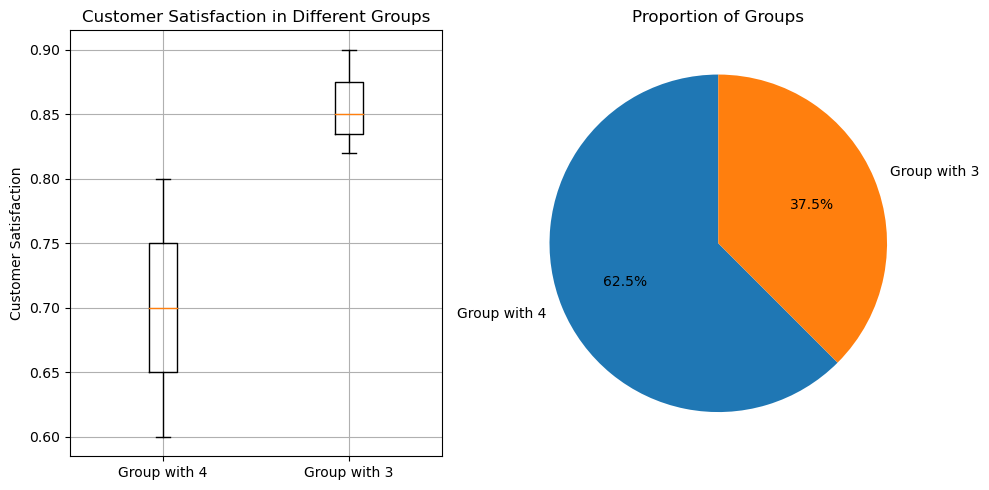

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Customer satisfaction data for the two groups
satisfaction_group_4 = [0.8, 0.7, 0.6, 0.65, 0.75] 
satisfaction_group_3 = [0.9, 0.85, 0.82]            

# Creating a figure and axes for the boxplot and pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Data for the boxplot
data = [satisfaction_group_4, satisfaction_group_3]

# Creating the boxplot
boxplot = ax1.boxplot(data)

# Adding labels to the axes
ax1.set_xticklabels(['Group with 4', 'Group with 3'])
ax1.set_ylabel('Customer Satisfaction')
ax1.set_title('Customer Satisfaction in Different Groups')
ax1.grid(True)

# Data for the pie chart
group_sizes = [len(satisfaction_group_4), len(satisfaction_group_3)]
group_labels = ['Group with 4', 'Group with 3']

# Creating the pie chart
ax2.pie(group_sizes, labels=group_labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Proportion of Groups')

# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')

# Displaying the plots
plt.tight_layout()
plt.show()
